# detecting polynomial classes from noisy data

The goal of this notebook is to interpret data in an x-y plane as a greyscale image. I want to use compare traditional MLPs with CNNs to classify unseen data and also check what happens if we confront the network with an unseen category of data. We go up to polynomials of degree 5 and randomly dice they coefficients. This can produce data that is pretty diverse.

## Training Data

The following function uses numpy to generate the data set. We make the output ndarray's shape configurable, but will stick with a 64x64 shaped plane that spans $x=(-32,32]$ or something alike.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def syn_image(x, values, yrange = None, shape = (32,32), value_span = (-1,1)):
    
    if type(yrange) == type(None):
        yrange = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
        
    current = np.zeros(shape)
    for ix in range(len(x)):
        yval = values[ix]
        xval = x[ix]
        if yval >= value_span[0] and yval <= value_span[-1]:
            yidx = len(x) -1 - np.searchsorted(yrange, yval, side="left")
            current[yidx,len(x) -1 - ix] = 1
            
    return current

def polynomials_as_images(size, max_degree, shape = (32,32), value_span = (-1,1), seed = 1, smear_sd = None):
    
    if seed:
        np.random.seed(seed)
        
    size = int(size)
    x = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[-1])
    y = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
    
    data   = np.zeros((size,int(shape[0]),int(shape[1])),
                       dtype=np.uint8)
    labels = np.random.randint(low=1,high=max_degree+1,size=size)
    
    for i in range(size):
        deg = labels[i]
        c   = np.random.random_sample(deg)
        #print(c)
        #print(x)
        values   = np.polynomial.polynomial.polyval(x,c)
        if smear_sd:
            smear_by = np.random.normal(1.,smear_sd,size=values.size)
            values = values*smear_by
        current = syn_image(x,values,y,shape,value_span)
            
        data[i,] = current
     
    return data, labels

In [127]:
train, labs = polynomials_as_images(5000,5,smear_sd=None)


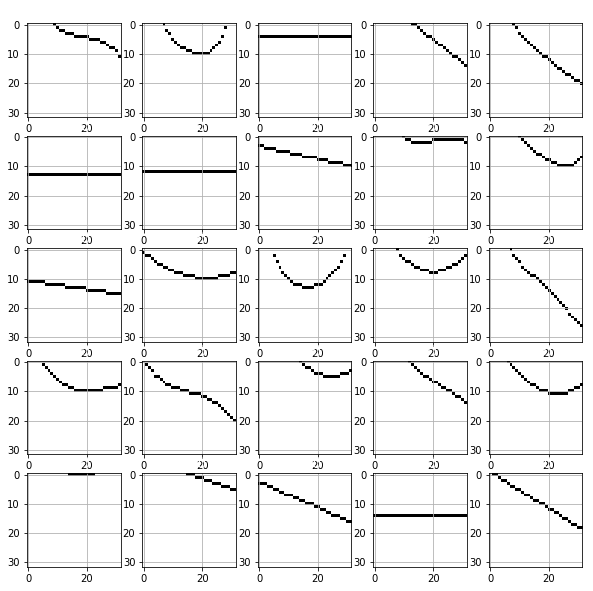

In [128]:
#nicer plots with axis labels etc
xticks = np.linspace(start=1, stop=-1,num=3)
yticks = np.linspace(start=1, stop=-1,num=3)

plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    #plt.xticks([])
    #plt.yticks([])
    plt.grid(True)
    plt.imshow(train[i], cmap=plt.cm.binary)
    #ax.xlabel("pol({0})".format(labs[i]),color='white')
    ax.set_title("pol({0})".format(labs[i]),color='white')

In [129]:
#MLP comes here with non-linearity
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten

labels = to_categorical(labs)
print(labels.shape)

model = Sequential()
model.add(Flatten(input_shape=(32,32)))
model.add(Dense(1024, activation='relu'))#all to all relation ship in first hidden layer
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

(5000, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_86 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_84 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_85 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 6)                 1542      


In [130]:
hist = model.fit(train, labels, epochs=20,
              validation_split = .05)

Train on 4750 samples, validate on 250 samples
Epoch 1/20
4750/4750 [==============================] - 2s 392us/step - loss: 1.1447 - acc: 0.4720 - val_loss: 0.9920 - val_acc: 0.5520
Epoch 2/20
4750/4750 [==============================] - 1s 132us/step - loss: 0.8026 - acc: 0.6541 - val_loss: 1.0217 - val_acc: 0.5440
Epoch 3/20
4750/4750 [==============================] - 1s 131us/step - loss: 0.6407 - acc: 0.7309 - val_loss: 1.0225 - val_acc: 0.5680
Epoch 4/20
4750/4750 [==============================] - 1s 131us/step - loss: 0.4863 - acc: 0.8040 - val_loss: 1.0391 - val_acc: 0.5920
Epoch 5/20
4750/4750 [==============================] - 1s 131us/step - loss: 0.3541 - acc: 0.8665 - val_loss: 1.2082 - val_acc: 0.6240
Epoch 6/20
4750/4750 [==============================] - 1s 131us/step - loss: 0.2570 - acc: 0.9084 - val_loss: 1.3779 - val_acc: 0.5760
Epoch 7/20
4750/4750 [==============================] - 1s 132us/step - loss: 0.1756 - acc: 0.9362 - val_loss: 1.6024 - val_acc: 0.6400
E

In [131]:
#CNN
from keras.layers import Conv2D, MaxPooling2D

train_ = train.reshape(train.shape[0],train.shape[1],train.shape[2],1)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 4, 4, 64)          36928     
__________

In [132]:
print(train_.shape)
chist = cnn.fit(train_, labels, epochs=20,
                  validation_split = .05)

(5000, 32, 32, 1)
Train on 4750 samples, validate on 250 samples
Epoch 1/20
4750/4750 [==============================] - 2s 465us/step - loss: 1.2806 - acc: 0.4099 - val_loss: 1.0581 - val_acc: 0.5200
Epoch 2/20
4750/4750 [==============================] - 1s 169us/step - loss: 0.9655 - acc: 0.5545 - val_loss: 0.9312 - val_acc: 0.5680
Epoch 3/20
4750/4750 [==============================] - 1s 169us/step - loss: 0.8347 - acc: 0.6259 - val_loss: 0.8402 - val_acc: 0.6160
Epoch 4/20
4750/4750 [==============================] - 1s 168us/step - loss: 0.7663 - acc: 0.6608 - val_loss: 0.7760 - val_acc: 0.6320
Epoch 5/20
4750/4750 [==============================] - 1s 168us/step - loss: 0.7270 - acc: 0.6823 - val_loss: 0.7241 - val_acc: 0.6720
Epoch 6/20
4750/4750 [==============================] - 1s 171us/step - loss: 0.6848 - acc: 0.6992 - val_loss: 0.6897 - val_acc: 0.6880
Epoch 7/20
4750/4750 [==============================] - 1s 169us/step - loss: 0.6642 - acc: 0.7124 - val_loss: 0.6958 -

In [133]:
def plot_loss_acc(hist):
    print(hist.params['metrics'])
    fig = plt.figure(figsize=(15,4));
  
    ax = fig.add_subplot(121)
    ax.semilogy(hist.epoch,hist.history['loss'],hist.history['val_loss'])
    ax.set_xlabel('epoch',color='w')
    ax.set_ylabel('loss',color='w')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend(['train','val/test'],loc='upper right')

    ax = fig.add_subplot(122)
    ax.plot(hist.epoch,hist.history['acc'],hist.history['val_acc'])
    ax.set_xlabel('epoch',color='w')
    ax.set_ylabel('accuracy',color='w') 
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend(['train','val/test'],loc='lower right')

['loss', 'acc', 'val_loss', 'val_acc']
['loss', 'acc', 'val_loss', 'val_acc']


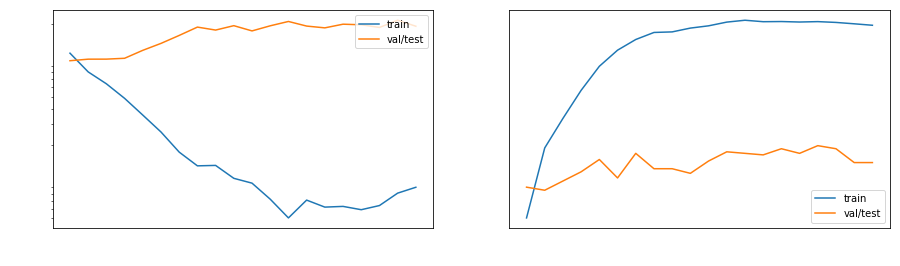

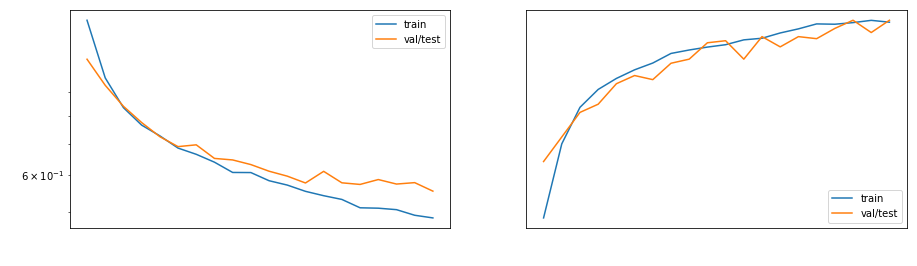

In [134]:
plot_loss_acc(hist)
plot_loss_acc(chist)